In [304]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
from __future__ import annotations

import datetime as dt

import polars as pl
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pyarrow.dataset as ds
import npc_lims
import numpy as np

import utils

dfs = utils.get_dfs()
units = ds.dataset(npc_lims.get_cache_path('units')).filter(ds.field('default_qc') == True)
epochs = utils.add_is_task_first_column(
    utils.add_epoch_name_column(dfs['epochs'])
)

In [9]:
%time
units = pl.scan_pyarrow_dataset(units)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs


In [10]:
units = utils.add_session_id_column(units)
units.head(1).collect(streaming=True)

num_spikes,firing_rate,presence_ratio,snr,isi_violations_ratio,isi_violations_count,rp_contamination,rp_violations,sliding_rp_violation,amplitude_cutoff,drift_ptp,drift_std,drift_mad,isolation_distance,l_ratio,d_prime,peak_to_valley,peak_trough_ratio,half_width,repolarization_slope,recovery_slope,electrode_group_name,peak_channel,cluster_id,default_qc,amplitude,channels,unit_id,group_name,ccf_ap,ccf_dv,ccf_ml,structure,location,peak_electrode,spike_times,obs_intervals,electrodes,waveform_mean,waveform_sd,device_name,session_idx,date,subject_id,id,session_id
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,i64,i64,bool,f64,list[i64],str,str,f64,f64,f64,str,str,i64,list[f64],list[list[f64]],list[i64],list[list[f32]],list[list[f32]],str,i64,date,i64,i64,str
28697.0,7.602027,0.951613,13.738011,0.003056,2.0,0.004594,2.0,0.005,0.00005,15.307829,3.058937,4.272146,101.515747,0.743907,4.411215,0.00074,-0.260198,0.000217,749399.217529,-81810.487934,"""probeF""",127,434,true,190.644531,"[119, 120, … 136]","""620263_2022-07…","""probeF""",4700.0,2100.0,5300.0,"""ACAd""","""ACAd5""",895,"[186.06981, 231.10156, … 3815.526702]","[[40.681284, 3815.585968]]","[887, 888, … 904]","[[-0.73476, 0.09828, … -0.739439], [-0.2106, 0.72072, … -0.29952], … [0.702, -0.996841, … 0.3276]]","[[18.319595, 24.935675, … 22.614162], [18.689837, 23.324684, … 21.559978], … [18.158464, 29.49519, … 22.509325]]","""18005121302""",0,2022-07-26,620263,851,"""620263_2022-07…"


In [11]:
# add columns to indicate whether session used 10 min or 20 min settle time
switched_to_notebook_workflow = dt.date(2023, 2, 6)     # notebook created with 20 min settle time

epochs['is_short_settle'] = epochs.date < switched_to_notebook_workflow

units = units.with_columns(
    pl.when(pl.col('date') < switched_to_notebook_workflow).then(True).otherwise(False).alias('is_short_settle')
)

In [12]:
# align spike times to start on 0 s
units = units.with_columns(
    pl.col('spike_times').map_elements(lambda x: x - x[0]).alias('spike_times')
)

In [15]:
# slow and requires ~60 GB RAM !
units = units.collect(streaming=True).to_pandas()

In [289]:
epochs.sort_values('start_time', inplace=True)

,start_time,stop_time,notes,name,session_idx,date,subject_id,session_id,is_ephys,is_templeton,is_training,is_dynamic_routing,is_opto,is_task_first,is_short_settle
4360,0.000000,3661.603974,,DynamicRouting1,0,2023-10-09,670242,670242_2023-10-09_0,False,False,True,True,False,True,False
4372,0.000000,4261.608951,,DynamicRouting1,0,2023-10-31,670242,670242_2023-10-31_0,False,False,True,True,False,True,False
4371,0.000000,4265.158053,,DynamicRouting1,0,2023-10-30,670242,670242_2023-10-30_0,False,False,True,True,False,True,False
4370,0.000000,4259.764763,,DynamicRouting1,0,2023-10-27,670242,670242_2023-10-27_0,False,False,True,True,False,True,False
4369,0.000000,4272.418889,,DynamicRouting1,0,2023-10-26,670242,670242_2023-10-26_0,False,False,True,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3447,16627.757640,20257.243480,,DynamicRouting1,0,2023-08-09,660023,660023_2023-08-09_0,True,False,False,True,False,False,False
3993,19502.401925,20102.871834,,SpontaneousRewards,0,2023-08-15,666986,666986_2023-08-15_0,True,False,False,True,False,False,False
3994,20114.698584,20401.752650,,OptoTagging,0,2023-08-15,666986,666986_2023-08-15_0,True,False,False,True,False,False,False
3448,20267.004722,20867.474532,,SpontaneousRewards,0,2023-08-09,660023,660023_2023-08-09_0,True,False,False,True,False,False,False


In [298]:
N_BINS = 100
START_SEC = 0
STOP_SEC = 60 * 60

def get_bins(start, stop, n_bins):
    bins = np.linspace(np.ceil(start), np.floor(stop), n_bins + 1)
    if len(bins) != n_bins + 1:
        import pdb; pdb.set_trace()
    return bins

def get_bin_size(bins):
    return np.median(np.diff(bins))

def get_timestamps(bins):
    return bins[:-1] + bin_size_sec / 2

def get_counts(units_df, start, stop) -> None | np.array[float]:
    bins = get_bins(start, stop, N_BINS)
    bin_size_sec = get_bin_size(bins)
    if bin_size_sec < 1: # skip epochs shorter than N_BINS seconds
        return None
    counts, _ = np.histogram(np.concatenate(units_df.spike_times.to_numpy(), axis=0), bins=N_BINS, range=(start, stop))
    if not counts.any():
        return None
    counts = counts - counts[0] # subtract baseline
    counts = counts / bin_size_sec / len(units_df) # normalize by bin size and number of units
    return counts

def get_epoch_times(epochs_df, session_id, epoch_name: str) -> tuple[tuple[float, float], ...] | None:
    e = epochs_df[epochs_df['session_id'] == session_id]
    epochs = e[e['name'] == epoch_name].sort_values('start_time')
    if epochs.empty:
        return None
    return tuple((a, b) for a, b in zip(epochs.start_time, epochs.stop_time))

bins = get_bins(START_SEC, STOP_SEC, N_BINS)
bin_size_sec = get_bin_size(bins)
t = get_timestamps(bins)

task_first: list[int] = []
late_task: list[int] = []

short_settle: list[int] = []
long_settle: list[int] = []

late_task_c: list[np.array[float]] = []
early_task_c: list[np.array[float]] = []

early_mapping_c: list[np.array[float]] = []
late_mapping_c: list[np.array[float]] = []

pre_task_c: dict[str, list[np.array[float]]] = {}
post_task_c: dict[str, list[np.array[float]]] = {}

c = []

ct = -1
for session_id, session_df in units.groupby('session_id'):
    for electrode_group_name, probe_df in session_df.groupby('electrode_group_name'):
        
        ct += 1
        
        counts = get_counts(probe_df, START_SEC, STOP_SEC)
        c.append(counts)
        assert len(counts) == N_BINS
        
        if session_df.is_short_settle.array.any():
            short_settle.append(ct)
        else:
            long_settle.append(ct)

        e = epochs[epochs['session_id'] == session_id]
        if any(e.is_task_first.array):
            task_first.append(ct)
        else:
            late_task.append(ct)     

        # store task counts on normalized timescale:
        epoch_times = get_epoch_times(e, session_id, 'DynamicRouting1')
        if epoch_times is not None:
            task_c = get_counts(probe_df, *epoch_times[0])
            if task_c is not None:
                if any(e.is_task_first.array):
                    early_task_c.append(task_c)
                else:
                    late_task_c.append(task_c)
                    
            task_start = epoch_times[0][0]
        else:
            continue
            
        # store mapping counts on normalized timescale:
        epoch_times = get_epoch_times(e, session_id, 'RFMapping')
        if epoch_times is not None:
            task_c = get_counts(probe_df, *epoch_times[0])
            if task_c is not None:
                if any(e.is_task_first.array):
                    late_mapping_c.append(task_c)
                else:
                    early_mapping_c.append(task_c)
        
        for name in ('Spontaneous', 'SpontaneousRewards', 'OptoTagging'):
            epoch_times = get_epoch_times(e, session_id, name)
            if epoch_times is None:
                continue
            for e_idx in (0, 1):
                if len(epoch_times) < e_idx + 1:
                    continue
                task_c = get_counts(probe_df, *epoch_times[0])
                if task_c is not None:
                    if epoch_times[e_idx][0] < task_start:
                        pre_task_c.setdefault(name, []).append(task_c)
                    else:
                        post_task_c.setdefault(name, []).append(task_c)
                        

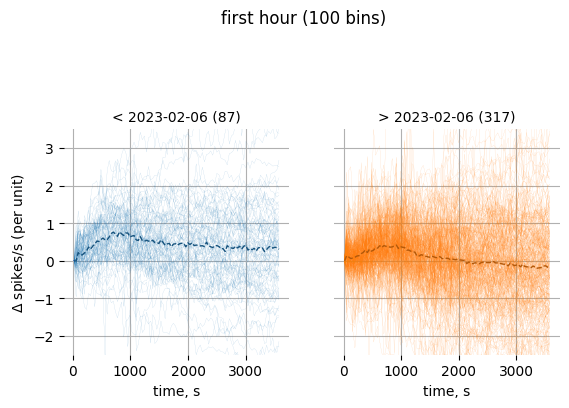

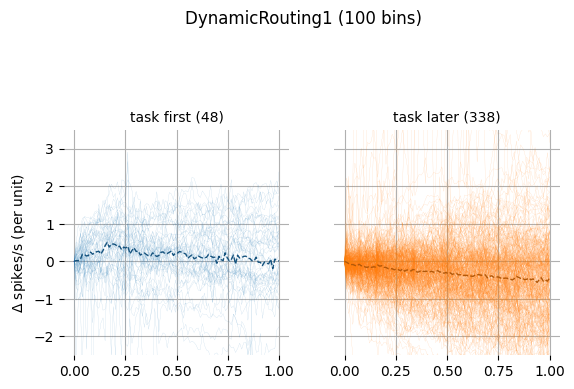

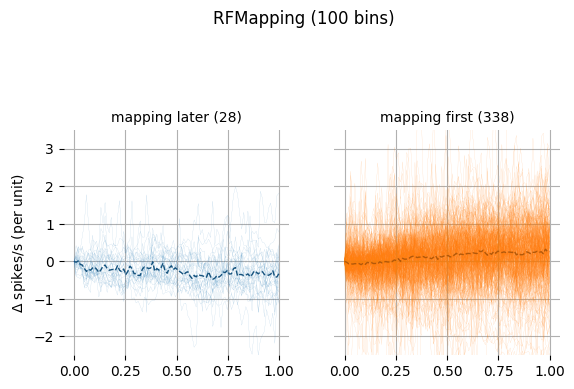

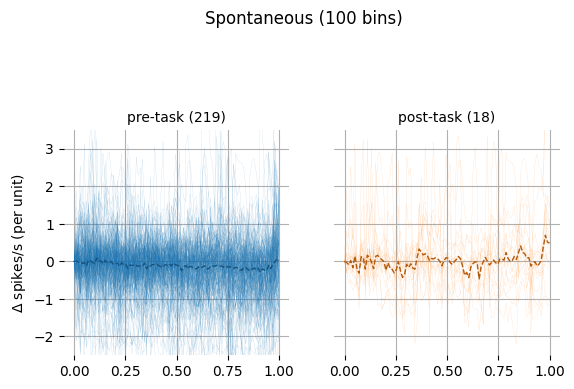

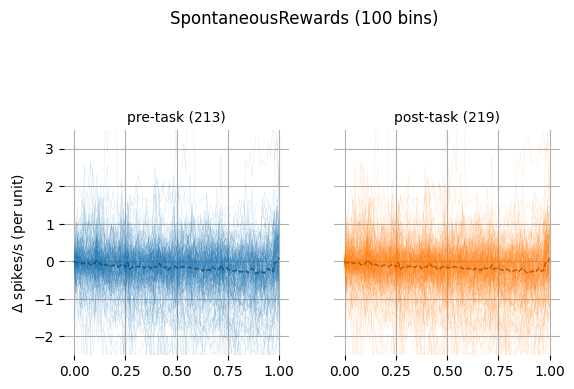

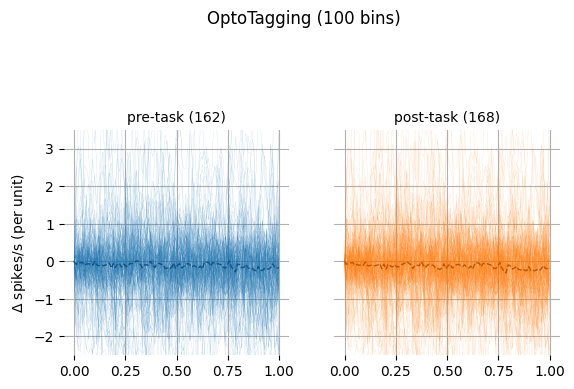

In [306]:
alpha = .5
lw = .1

def plot(values, ax, col_idx, norm: bool = False):
    color = plt.get_cmap("tab10")(col_idx)[:3]
    if norm:
        time = np.linspace(0, 1, N_BINS) 
    else:
        time = t
    values = np.array(values)
    ax.plot(
        np.array([time] * len(values)).T, values.T, 
        color=[*color, alpha],
        lw=lw,
    );
    ax.plot(
        time, np.median(values, axis=0), 
        color=np.array(color)*.7,
        lw=1,
        linestyle='--',
    );
    
def set_ax(ax, ax_idx, title, norm: bool = False):
    ax.title.set_text(title)
    ax.title.set_fontsize(10)
    ax.set_ylim(-2.5, 3.5)
    # ax.set_xmargin(0)
    ax.set_aspect(np.diff(ax.get_xlim())/np.diff(ax.get_ylim()))
    ax.grid(True)
    ax.set_frame_on(False)
    # ax.set_xlim([0, STOP_SEC])
    if norm:
        ax.set_xlabel('')
    else:
        ax.set_xlabel('time, s')
    if ax_idx == 0:
        ax.set_ylabel('$\Delta$ spikes/s (per unit)')
    else:
        ax.yaxis.set_ticks_position('none') 
    
# fig, _ = plt.subplots(1,2, sharey=True)
# plot(c[task_first], fig.axes[0], 0)
# plot(c[late_task], fig.axes[1], 1)
# set_ax(fig.axes[0], 0, f'task first ({len(task_first)})')
# set_ax(fig.axes[1], 1, f'task later ({len(late_task)})')
# fig.suptitle('first hour')

fig, _ = plt.subplots(1,2, sharey=True)
plot(np.array(c)[short_settle], fig.axes[0], 0)
plot(np.array(c)[long_settle], fig.axes[1], 1)
set_ax(fig.axes[0], 0, f'< 2023-02-06 ({len(short_settle)})')
set_ax(fig.axes[1], 1, f'> 2023-02-06 ({len(long_settle)})')
fig.suptitle(f'first hour ({N_BINS} bins)');

fig, _ = plt.subplots(1,2, sharey=True)
plot(early_task_c, fig.axes[0], 0, norm=True)
plot(late_task_c, fig.axes[1], 1, norm=True)
set_ax(fig.axes[0], 0, f'task first ({len(early_task_c)})', norm=True)
set_ax(fig.axes[1], 1, f'task later ({len(late_task_c)})', norm=True)
fig.suptitle(f'DynamicRouting1 ({N_BINS} bins)');

fig, _ = plt.subplots(1,2, sharey=True)
plot(late_mapping_c, fig.axes[0], 0, norm=True)
plot(early_mapping_c, fig.axes[1], 1, norm=True)
set_ax(fig.axes[0], 0, f'mapping later ({len(late_mapping_c)})', norm=True)
set_ax(fig.axes[1], 1, f'mapping first ({len(early_mapping_c)})', norm=True)
fig.suptitle(f'RFMapping ({N_BINS} bins)');

for name in ('Spontaneous', 'SpontaneousRewards', 'OptoTagging'):
    fig, _ = plt.subplots(1,2, sharey=True)
    plot(pre_task_c[name], fig.axes[0], 0, norm=True)
    plot(post_task_c[name], fig.axes[1], 1, norm=True)
    set_ax(fig.axes[0], 0, f'pre-task ({len(pre_task_c[name])})', norm=True)
    set_ax(fig.axes[1], 1, f'post-task ({len(post_task_c[name])})', norm=True)
    fig.suptitle(f'{name} ({N_BINS} bins)');

In [341]:
structures = ('ACAd', 'MOp', 'VISp', 'CA1', 'ORBl')
structures = units.structure.unique()

structure_task_c: dict[str, list[np.array[float]]] = {}

for structure in structures:
    structure_df = units[units['structure'] == structure]
    for session_id, session_df in structure_df.groupby('session_id'):
    
        e = epochs[epochs['session_id'] == session_id]
        # store task counts on normalized timescale:
        epoch_times = get_epoch_times(e, session_id, 'DynamicRouting1')
        if epoch_times is not None:
            task_c = get_counts(session_df, *epoch_times[0])
            if task_c is not None:
                structure_task_c.setdefault(structure, []).append(task_c)
[len(_) for _ in structure_task_c.values()]

[20,
 15,
 41,
 26,
 45,
 3,
 20,
 49,
 7,
 11,
 42,
 23,
 11,
 25,
 4,
 37,
 44,
 12,
 49,
 7,
 6,
 5,
 28,
 32,
 7,
 7,
 3,
 10,
 16,
 23,
 16,
 10,
 4,
 9,
 16,
 6,
 13,
 43,
 11,
 40,
 7,
 7,
 26,
 7,
 4,
 21,
 21,
 15,
 31,
 6,
 8,
 7,
 3,
 11,
 9,
 7,
 1,
 11,
 1,
 21,
 17,
 17,
 11,
 5,
 2,
 9,
 14,
 10,
 10,
 19,
 21,
 25,
 19,
 5,
 15,
 7,
 5,
 2,
 6,
 3,
 8,
 6,
 15,
 2,
 8,
 11,
 8,
 1,
 8,
 16,
 11,
 10,
 9,
 8,
 5,
 2,
 17,
 7,
 3,
 1,
 2,
 3,
 12,
 10,
 8,
 6,
 7,
 1,
 2,
 2,
 2,
 2,
 4,
 1,
 5,
 1,
 4,
 4,
 3,
 5,
 2,
 1,
 2,
 2,
 4,
 4,
 2,
 2,
 2,
 2,
 1,
 2,
 1,
 2,
 3,
 2,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 3,
 3,
 1,
 1,
 2,
 2,
 1,
 1,
 1,
 1,
 2]

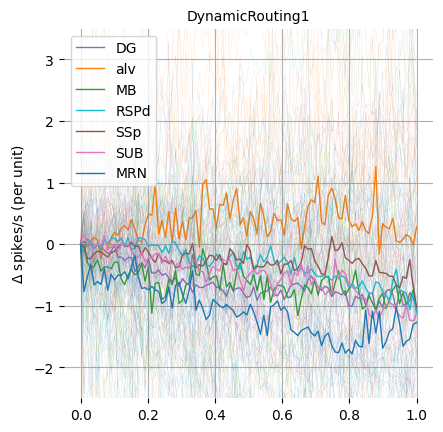

In [383]:
alpha = 1
lw = 1

def plot(values, ax, col_idx, name, norm: bool = False):
    color = plt.get_cmap("tab10")(col_idx % 10)[:3]
    if norm:
        time = np.linspace(0, 1, N_BINS) 
    else:
        time = t
    values = np.array(values)
    if np.abs(np.median(values, axis=0)).max() < 1:
        return
    ax.plot(
        np.array([time] * len(values)).T, values.T, 
        color=[*color, .5],
        lw=.1,
    );
    ax.plot(
        time, np.median(values, axis=0), 
        color=np.array(color),
        lw=1,
        linestyle='-',
        label=name,
    );
    
def set_ax(ax, ax_idx, title, norm: bool = False):
    ax.title.set_text(title)
    ax.title.set_fontsize(10)
    ax.set_ylim(-2.5, 3.5)
    # ax.set_xmargin(0)
    ax.set_aspect(np.diff(ax.get_xlim())/np.diff(ax.get_ylim()))
    ax.grid(True)
    ax.set_frame_on(False)
    # ax.set_xlim([0, STOP_SEC])
    if norm:
        ax.set_xlabel('')
    else:
        ax.set_xlabel('time, s')
    if ax_idx == 0:
        ax.set_ylabel('$\Delta$ spikes/s (per unit)')
    else:
        ax.yaxis.set_ticks_position('none') 
    ax.legend()
    
fig = plt.figure()
ax = plt.gca()

for idx, (name, values) in enumerate(structure_task_c.items()):
    if len(values) < 20:
        continue
    plot(values, ax, idx, name, norm=True)
set_ax(ax, 0, 'DynamicRouting1', norm=True)